In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
########################   读取数据  #########################################
sheet = pd.read_excel('data_input/中国10债Non-Trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
full_date_range = pd.date_range(start=sheet.index.min(), end=sheet.index.max()+pd.Timedelta(days=60), freq='D') 
sheet = sheet.reindex(full_date_range)
# 有月度数据 所以 数据 处理逻辑 就是 全部填充 然后再变成 工作日数据
#############  处理缺失值 ##############
fill_methods = {
    '10年期美国国债收益率80日环差': 'interpolate',
    '南华工业品指数80日环比':'interpolate',
    '新增人民币贷款/中长期同差':'interpolate',  # 月度数据
    'M2同比': 'interpolate', # 月度数据
    'M1同比': 'interpolate', # 月度数据
    'DR007利率/15DMA': 'interpolate',
    'CNH HIBOR/3M（同花顺）': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
last_day = sheet['中国10年期国债收益率Non-Trend/F0.2'].last_valid_index()
sheet = sheet.reset_index().rename(columns={'index': 'Date'})
########## 只保留工作日数据(周一到周五) ##########
sheet = sheet[sheet['Date'].dt.dayofweek < 5]
sheet_daily = sheet.copy()
########################   因子处理  #########################################
sheet_daily['10年期美国国债收益率80日环差_提前80天'] = sheet_daily['10年期美国国债收益率80日环差'].shift(80)
sheet_daily['南华工业品指数80日环比_提前55天'] = sheet_daily['南华工业品指数80日环比'].shift(55)
sheet_daily['新增人民币贷款/中长期同差_提前160天'] = sheet_daily['新增人民币贷款/中长期同差'].shift(160)
sheet_daily['M2同比_提前140天'] = sheet_daily['M2同比'].shift(140)
sheet_daily['M1同比_提前60天'] = sheet_daily['M1同比'].shift(60)
sheet_daily['DR007利率/15DMA_提前30天'] = sheet_daily['DR007利率/15DMA'].shift(30)
sheet_daily['CNH HIBOR/3M（同花顺）_提前60天'] = sheet_daily['CNH HIBOR/3M（同花顺）'].shift(60)

sheet_daily = sheet_daily[sheet_daily['Date'] >= '2020-08-01']  
############ 不同因子有效期不同  ##########
sheet_daily['10年期美国国债收益率80日环差_提前80天_2023-01-01之后'] = sheet_daily['10年期美国国债收益率80日环差_提前80天'].loc[sheet_daily['Date'] >= '2023-01-01']
sheet_daily['南华工业品指数80日环比_提前55天_2022-11-01之后'] = sheet_daily['南华工业品指数80日环比_提前55天'].loc[sheet_daily['Date'] >= '2022-11-01']
#############  删除预测指标最后一天之前 为空值的一整行  ##############
sheet_daily = sheet_daily[(sheet_daily['Date'] > last_day) | sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].notna()]

In [4]:
sheet_daily.columns

Index(['Date', '中国10年期国债收益率Non-Trend/F0.2', '10年期美国国债收益率80日环差', '南华工业品指数80日环比',
       '新增人民币贷款/中长期同差', 'M2同比', 'M1同比', 'DR007利率/15DMA', 'CNH HIBOR/3M（同花顺）',
       '10年期美国国债收益率80日环差_提前80天', '南华工业品指数80日环比_提前55天', '新增人民币贷款/中长期同差_提前160天',
       'M2同比_提前140天', 'M1同比_提前60天', 'DR007利率/15DMA_提前30天',
       'CNH HIBOR/3M（同花顺）_提前60天', '10年期美国国债收益率80日环差_提前80天_2023-01-01之后',
       '南华工业品指数80日环比_提前55天_2022-11-01之后'],
      dtype='object')

In [5]:
sheet_daily.head()

,Date,中国10年期国债收益率Non-Trend/F0.2,10年期美国国债收益率80日环差,南华工业品指数80日环比,新增人民币贷款/中长期同差,M2同比,M1同比,DR007利率/15DMA,CNH HIBOR/3M（同花顺）,10年期美国国债收益率80日环差_提前80天,南华工业品指数80日环比_提前55天,新增人民币贷款/中长期同差_提前160天,M2同比_提前140天,M1同比_提前60天,DR007利率/15DMA_提前30天,CNH HIBOR/3M（同花顺）_提前60天,10年期美国国债收益率80日环差_提前80天_2023-01-01之后,南华工业品指数80日环比_提前55天_2022-11-01之后
10443,2020-08-03,-0.1132,-0.21,0.1641,3945.612903,10.670968,7.006452,2.1468,2.7396,-1.13,-0.1237,3092.032258,8.506452,5.961290,1.939600,2.2856,NaN,NaN
10444,2020-08-04,-0.1148,-0.21,0.1521,3947.483871,10.661290,7.041935,2.1476,2.8000,-1.13,-0.1134,3173.903226,8.496774,6.003226,1.979600,2.2370,NaN,NaN
10445,2020-08-05,-0.0834,-0.21,0.1468,3949.354839,10.651613,7.077419,2.1384,2.7848,-1.29,-0.1074,3255.774194,8.487097,6.045161,1.991200,2.2873,NaN,NaN
10446,2020-08-06,-0.0760,-0.21,0.1406,3951.225806,10.641935,7.112903,2.1222,2.8340,-1.31,-0.0989,3337.645161,8.477419,6.087097,1.992675,2.3736,NaN,NaN
10447,2020-08-07,-0.0736,-0.06,0.1284,3953.096774,10.632258,7.148387,2.1196,2.8531,-1.27,-0.1209,3419.516129,8.467742,6.129032,1.994150,2.2873,NaN,NaN


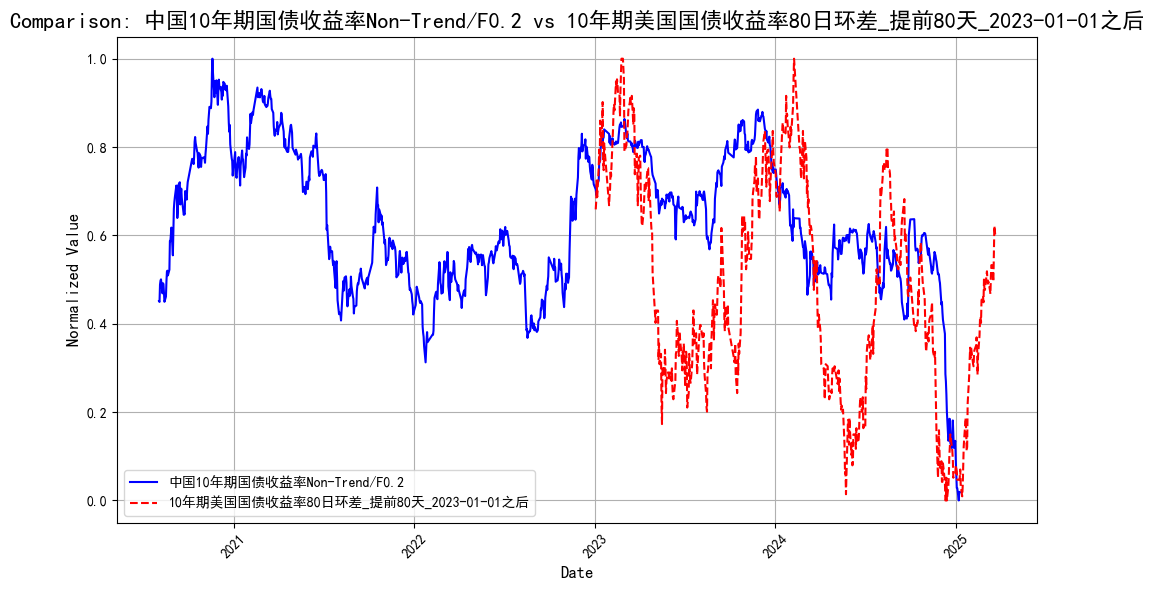

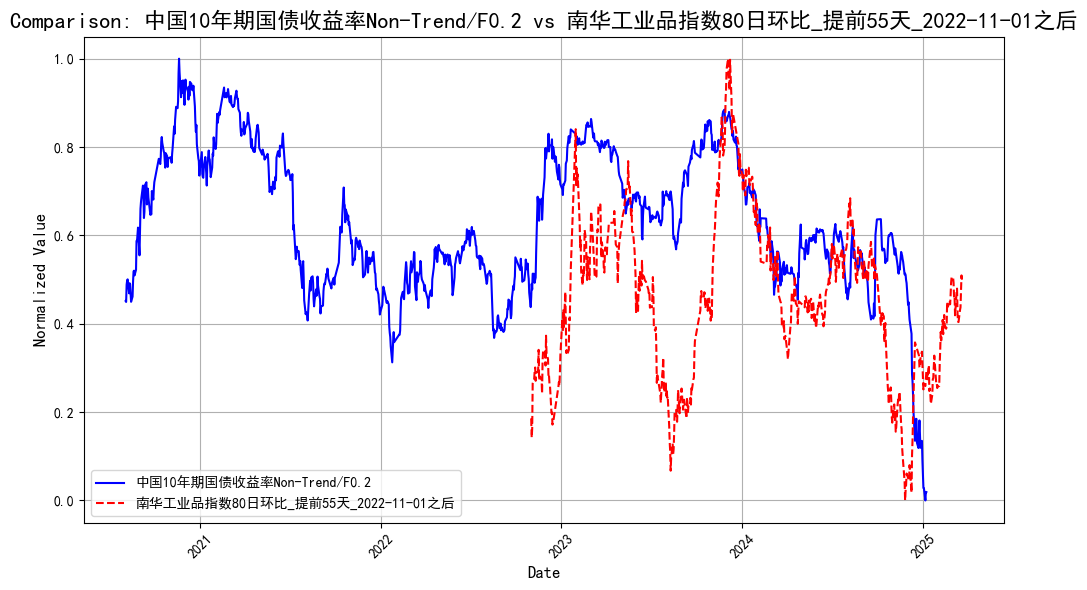

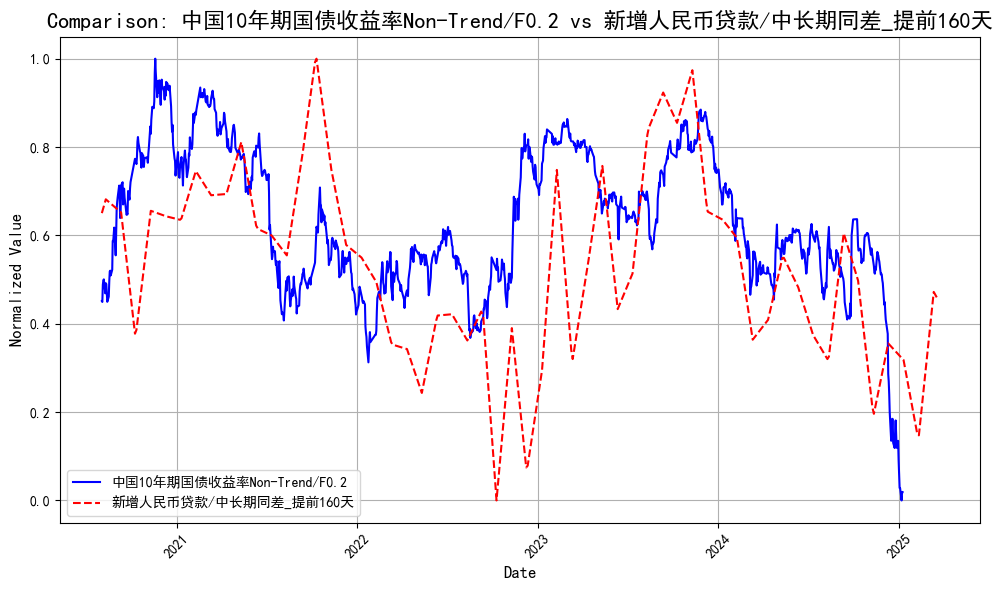

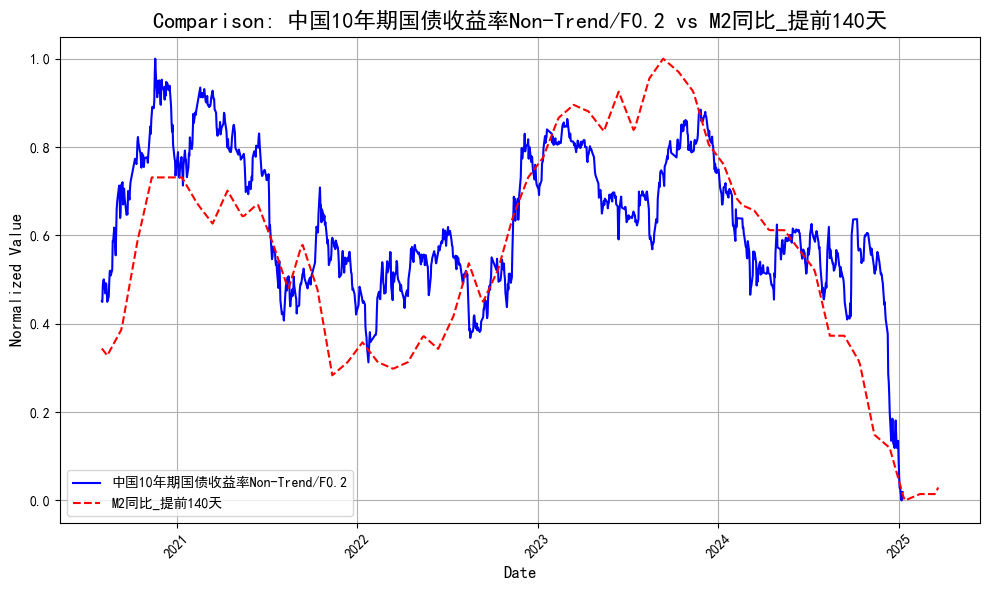

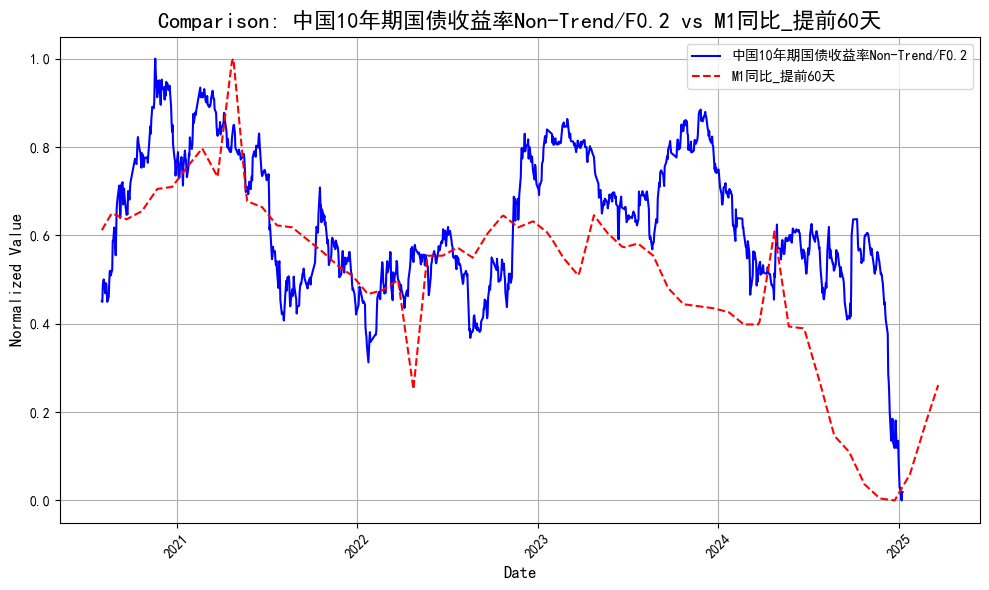

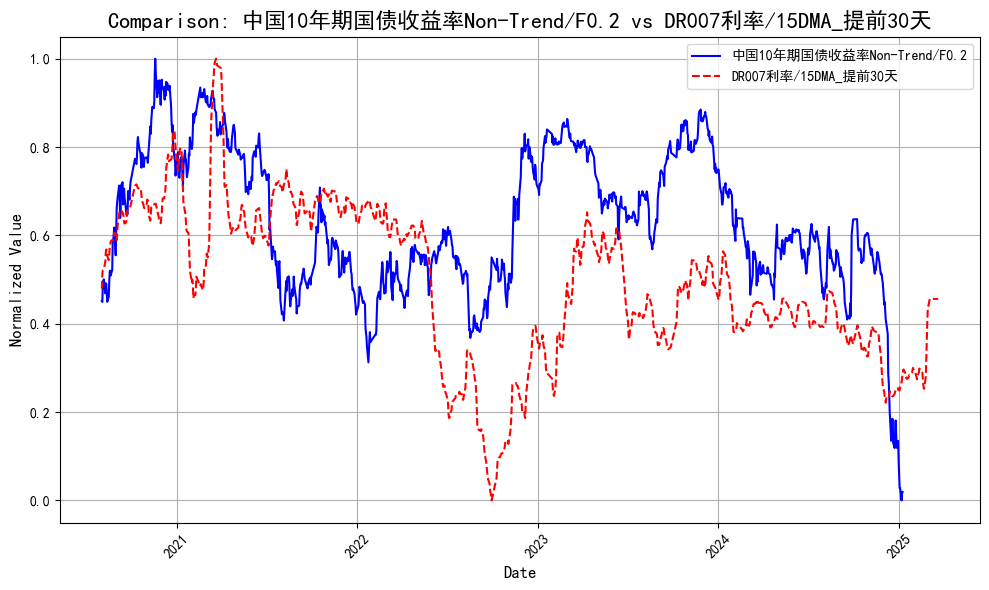

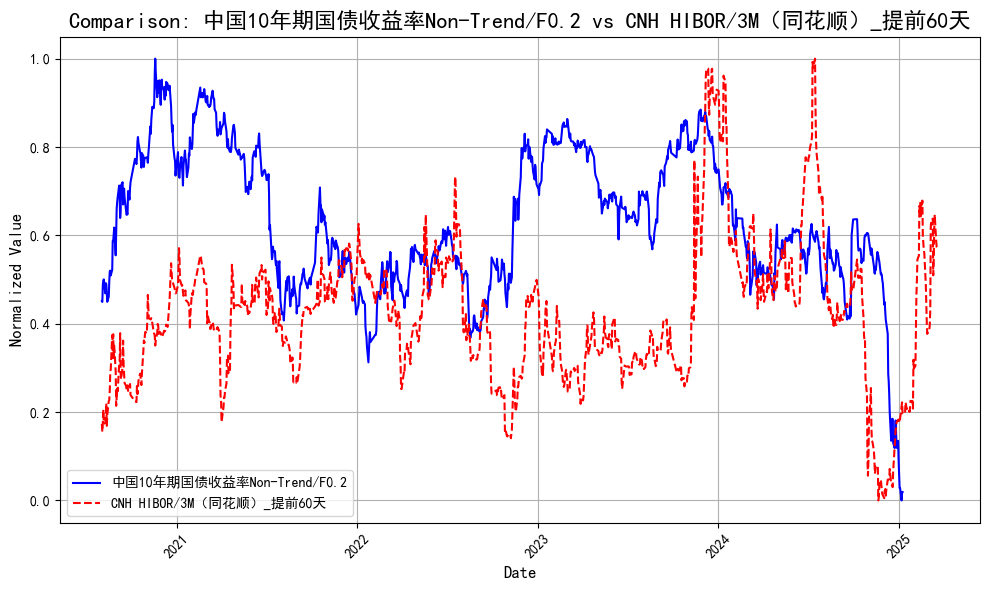

In [6]:
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='中国10年期国债收益率Non-Trend/F0.2', 
    compare_cols=[ '10年期美国国债收益率80日环差_提前80天_2023-01-01之后','南华工业品指数80日环比_提前55天_2022-11-01之后',
                  '新增人民币贷款/中长期同差_提前160天','M2同比_提前140天','M1同比_提前60天',
                  'DR007利率/15DMA_提前30天','CNH HIBOR/3M（同花顺）_提前60天']
)

In [7]:

# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 100
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]


'''


## 原来的数据存储到别的地方
real_data = sheet_daily.copy()
# 动态调整训练数据起始日期
train_start_date = '2023-02-25'  # 可调整的训练数据起始日期
sheet_daily = sheet_daily[sheet_daily['Date'] <= train_start_date]


# 划分训练、测试和未来数据
def split_data(sheet, last_day):
    train_data = sheet[sheet['Date'] <= last_day]
    test_data = train_data[-1:]
    train_data = train_data[:-1]
    future_data = sheet[sheet['Date'] > last_day].copy()
    future_data['中国10年期国债收益率Non-Trend/F0.2'] = None
    return train_data, test_data, future_data

last_day = sheet_daily[sheet_daily['Date'].dt.dayofweek < 5]['Date'].max() - pd.Timedelta(days=30)

train_data, test_data, future_data = split_data(sheet_daily, last_day)
'''

"\n\n\n## 原来的数据存储到别的地方\nreal_data = sheet_daily.copy()\n# 动态调整训练数据起始日期\ntrain_start_date = '2023-02-25'  # 可调整的训练数据起始日期\nsheet_daily = sheet_daily[sheet_daily['Date'] <= train_start_date]\n\n\n# 划分训练、测试和未来数据\ndef split_data(sheet, last_day):\n    train_data = sheet[sheet['Date'] <= last_day]\n    test_data = train_data[-1:]\n    train_data = train_data[:-1]\n    future_data = sheet[sheet['Date'] > last_day].copy()\n    future_data['中国10年期国债收益率Non-Trend/F0.2'] = None\n    return train_data, test_data, future_data\n\nlast_day = sheet_daily[sheet_daily['Date'].dt.dayofweek < 5]['Date'].max() - pd.Timedelta(days=30)\n\ntrain_data, test_data, future_data = split_data(sheet_daily, last_day)\n"

In [8]:
last_day

Timestamp('2025-01-08 00:00:00')

In [9]:
feature_columns = [
    '10年期美国国债收益率80日环差_提前80天_2023-01-01之后',
    '南华工业品指数80日环比_提前55天_2022-11-01之后',
    '新增人民币贷款/中长期同差_提前160天',
    'M2同比_提前140天',
    'M1同比_提前60天',
    'DR007利率/15DMA_提前30天',
    'CNH HIBOR/3M（同花顺）_提前60天'
]

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns]
y_train = train_data['中国10年期国债收益率Non-Trend/F0.2']

X_test = test_data[feature_columns]
y_test = test_data['中国10年期国债收益率Non-Trend/F0.2']

X_future = future_data[feature_columns]

In [11]:
default_params = {
    "n_estimators": 400,
    "max_depth": 4,
    "learning_rate": 0.05,
    "objective": "reg:squarederror",
    "booster": "gbtree", # 'gblinear' 用于简单线性关系的任务。'dart' 可适应稀疏数据或更复杂的关系。
    "gamma": 0.2,
    "min_child_weight": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "colsample_bylevel": 1,
    "colsample_bynode": 1,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "scale_pos_weight": 1,  #在类别不平衡时，适当调整此值可以提高模型对少数类别的表现。
    "base_score": 0.5,
    "random_state": 0,
    "verbosity": 1,
    "early_stopping_rounds": None,  # 默认未启用
    "tree_method": "auto",
    "max_delta_step": 0,
}


xgb = XGBRegressor(**default_params)

# 训练模型，并设置 early_stopping_rounds
xgb.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
y_future_pred = xgb.predict(X_future)

[0]	validation_0-rmse:0.44479	validation_1-rmse:0.60584
[1]	validation_0-rmse:0.42307	validation_1-rmse:0.58226
[2]	validation_0-rmse:0.40249	validation_1-rmse:0.55971
[3]	validation_0-rmse:0.38290	validation_1-rmse:0.53655
[4]	validation_0-rmse:0.36433	validation_1-rmse:0.51498
[5]	validation_0-rmse:0.34661	validation_1-rmse:0.49422
[6]	validation_0-rmse:0.32983	validation_1-rmse:0.47440
[7]	validation_0-rmse:0.31409	validation_1-rmse:0.45628
[8]	validation_0-rmse:0.29907	validation_1-rmse:0.44047
[9]	validation_0-rmse:0.28471	validation_1-rmse:0.42407
[10]	validation_0-rmse:0.27117	validation_1-rmse:0.40861
[11]	validation_0-rmse:0.25831	validation_1-rmse:0.39470
[12]	validation_0-rmse:0.24609	validation_1-rmse:0.38086
[13]	validation_0-rmse:0.23457	validation_1-rmse:0.36768
[14]	validation_0-rmse:0.22378	validation_1-rmse:0.35788
[15]	validation_0-rmse:0.21331	validation_1-rmse:0.34564
[16]	validation_0-rmse:0.20339	validation_1-rmse:0.33401
[17]	validation_0-rmse:0.19414	validation

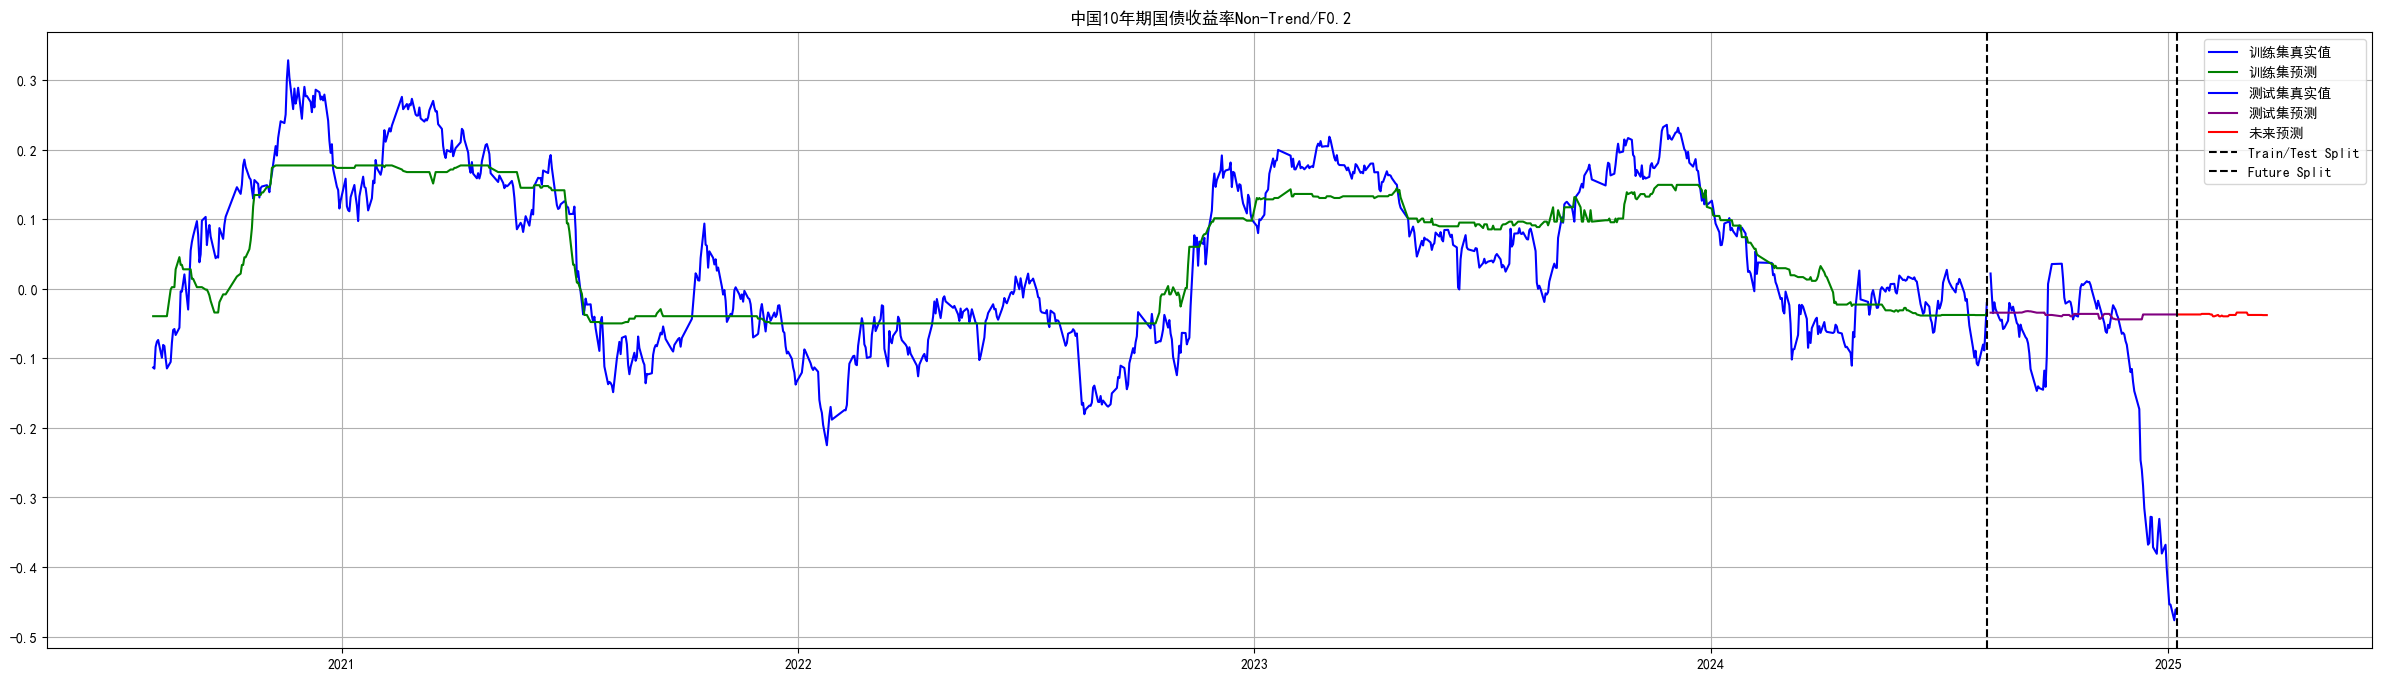

In [13]:
'''
# 获取真实数据
real_data = sheet_daily[
    (sheet_daily['Date'] > last_day) & 
    (sheet_daily['Date'] <= last_day + pd.Timedelta(days=30))
]
'''

plt.figure(figsize=(30, 8))
plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue')
plt.plot(test_data['Date'], y_test_pred, label='测试集预测', color='purple')
plt.plot(future_data['Date'], y_future_pred, label='未来预测', color='red')

# 在同一张图中添加真实数据线
#plt.plot(real_data['Date'], real_data['中国10年期国债收益率Non-Trend/F0.2'], label='未来30天真实值', color='orange', linestyle='--', linewidth=2)

plt.axvline(x=train_data['Date'].iloc[-1], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('中国10年期国债收益率Non-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()
